# Path Planning with KDTree and A* in NetworkX
This notebook implements a path planning solution using:
- KDTree for efficient nearest neighbor search
- A* algorithm for pathfinding
- NetworkX for graph operations
- Shapely for polygon operations

## Import Required Libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

plt.rcParams['figure.figsize'] = 12, 12

## Load and Process Data
Loading collision data from CSV file. The data contains obstacle information in the format:
- north coordinate
- east coordinate
- altitude
- half width
- half length
- height

In [36]:
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Define Custom Polygon Class
Creating a custom polygon class to handle obstacle geometries and properties

In [37]:
import numpy as np
from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, Point

class Poly:

    def __init__(self, coords, height):
        self._polygon = Polygon(coords)
        self._height = height

    @property
    def height(self):
        return self._height

    @property
    def coords(self):
        return list(self._polygon.exterior.coords)[:-1]
    
    @property
    def area(self):
        return self._polygon.area

    @property
    def center(self):
        return (self._polygon.centroid.x, self._polygon.centroid.y)

    def contains(self, point):
        point = Point(point)
        return self._polygon.contains(point)

    def crosses(self, other):
        return self._polygon.crosses(other)



def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        obstacle = [north - d_north, north + d_north, east - d_east, east + d_east]
        corners = [(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        p = Poly(corners, height)
        polygons.append(p)

    return polygons


## Implement Sampling Class
The Sampler class handles:
- Creating polygon obstacles from data
- Defining the sampling space
- Generating valid random samples outside obstacles

In [38]:


class Sampler:

    def __init__(self, data):
        self._polygons = extract_polygons(data)
        self._xmin = np.min(data[:, 0] - data[:, 3])
        self._xmax = np.max(data[:, 0] + data[:, 3])

        self._ymin = np.min(data[:, 1] - data[:, 4])
        self._ymax = np.max(data[:, 1] + data[:, 4])

        self._zmin = 0
        # limit z-axis
        self._zmax = 20

        centers = np.array([p.center for p in self._polygons])
        self._tree = KDTree(centers, metric='euclidean')

    def sample(self, num_samples):
        """Implemented with a k-d tree for efficiency."""
        xvals = np.random.uniform(self._xmin, self._xmax, num_samples)
        yvals = np.random.uniform(self._ymin, self._ymax, num_samples)
        zvals = np.random.uniform(self._zmin, self._zmax, num_samples)
        samples = list(zip(xvals, yvals, zvals))

        pts = []
        for s in samples:
            _, idx = self._tree.query(np.array([s[0], s[1]]).reshape(1, -1))
            p = self._polygons[int(idx)]
            if not p.contains(s) or p.height < s[2]:
                pts.append(s)
        return pts

    @property
    def polygons(self):
        return self._polygons

## Graph Creation and Path Planning Functions
Implementing:
- Graph creation using KDTree for nearest neighbors
- A* pathfinding algorithm

In [39]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [int(np.clip(north - d_north - safety_distance - north_min, 0, north_size - 1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size - 1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size - 1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size - 1)),]
            grid[obstacle[0]:obstacle[1] + 1, obstacle[2]:obstacle[3] + 1] = 1

    return grid

In [40]:
sampler = Sampler(data)
polygons = sampler.polygons

# Example: sampling 100 points and removing ones conflicting with obstacles.

In [23]:
nodes = sampler.sample(300)
print(len(nodes))

204


C:\Users\Huthaifa\AppData\Local\Temp\ipykernel_15144\1882809663.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = self._polygons[int(idx)]
C:\Users\Huthaifa\AppData\Local\Temp\ipykernel_15144\1882809663.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = self._polygons[int(idx)]
C:\Users\Huthaifa\AppData\Local\Temp\ipykernel_15144\1882809663.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = self._polygons[int(idx)]
C:\Users\Huthaifa\AppData\Local

In [24]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree


# In[29]:
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

In [25]:
def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]

        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

In [26]:
import time
t0 = time.time()
g = create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time() - t0))




graph took 50.94814109802246 seconds to build


In [27]:
print("Number of edges", len(g.edges))

Number of edges 566


In [28]:
grid = create_grid(data, sampler._zmax, 1)

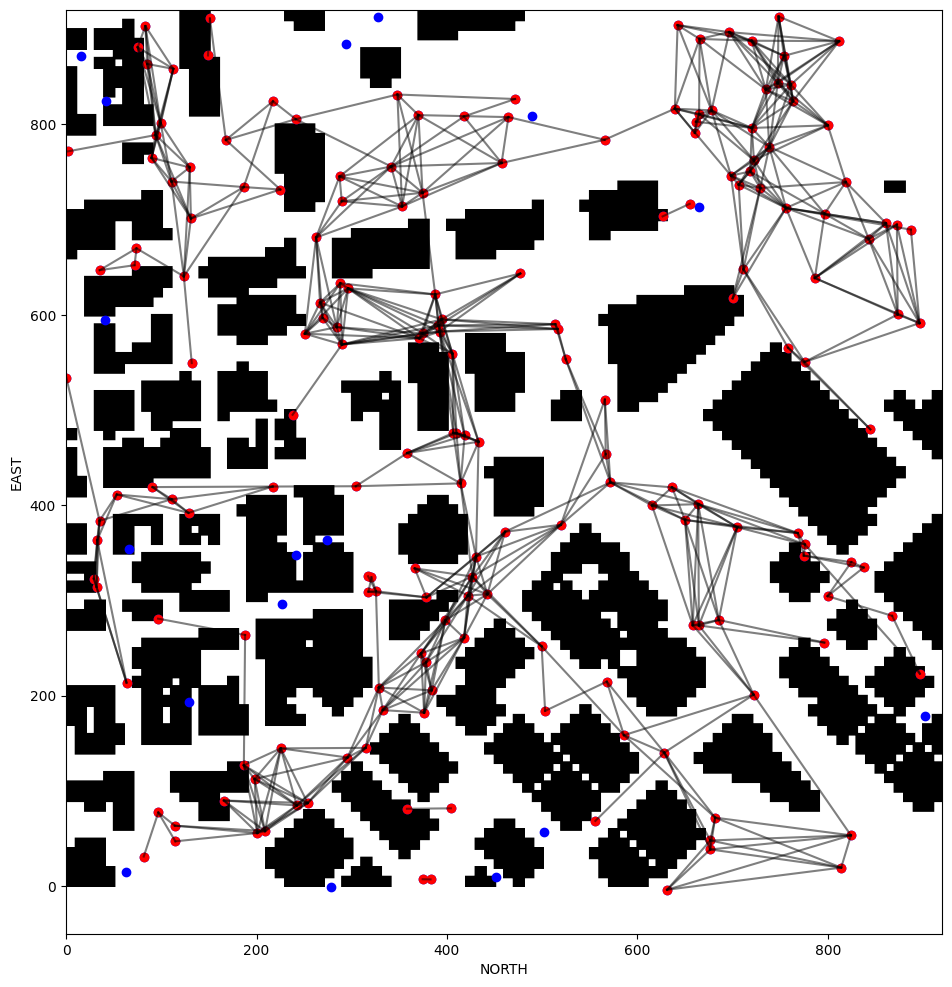

In [29]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# draw all nodes
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [ ]:

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))


def a_star(graph, heuristic, start, goal):

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [56]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

88 187


In [57]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

Found a path.
3 [(497.4618165799406, 25.351191416489826, 13.593646505487305), (473.63695111578903, 126.39824458392798, 15.162088505737639), (506.30538422014473, 200.18224236399737, 12.824001583359987)]


In [58]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(497.4618165799406, 25.351191416489826, 13.593646505487305) (473.63695111578903, 126.39824458392798, 15.162088505737639)
(473.63695111578903, 126.39824458392798, 15.162088505737639) (506.30538422014473, 200.18224236399737, 12.824001583359987)


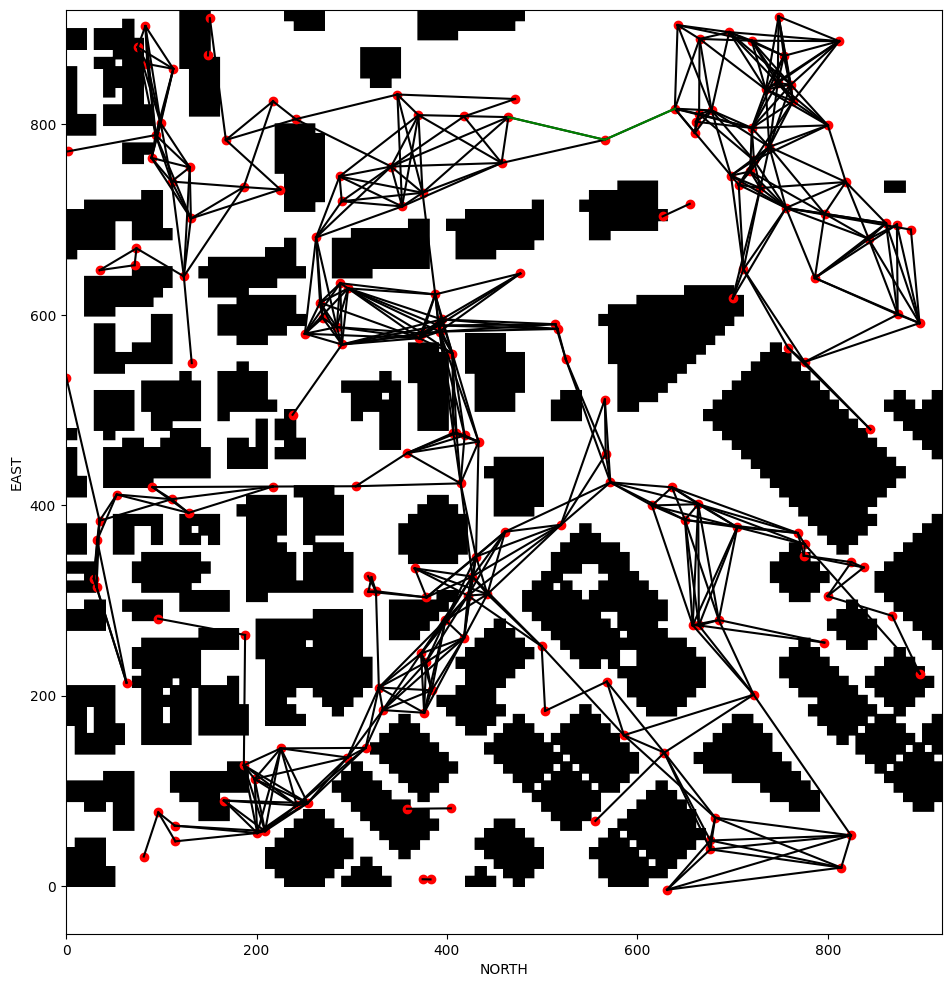

In [59]:

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()